In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os

# Parameters
epsilon = 1  # The probability of choosing a random action (in training). This decays as iterations increase. (0 to 1)
epsilonMinimumValue = 0.001 # The minimum value we want epsilon to reach in training. (0 to 1)
nbActions = 3 # The number of actions. Since we only have left/stay/right that means 3 actions.
epoch = 2000 # The number of games we want the system to run for.
hiddenSize = 100 # Number of neurons in the hidden layers.
maxMemory = 500 # How large should the memory be (where it stores its past experiences).
batchSize = 50 # The mini-batch size for training. Samples are randomly taken from memory till mini-batch size.
gridSize = 10 # The size of the grid that the agent is going to play the game on.
nbStates = gridSize * gridSize # We eventually flatten to a 1d tensor to feed the network.
discount = 0.9 # The discount is used to force the network to choose states that lead to the reward quicker (0 to 1)  
learningRate = 0.2 # Learning Rate for Stochastic Gradient Descent (our optimizer).

# Create the base model.
X = tf.placeholder(tf.float32, [None, nbStates])
W1 = tf.Variable(tf.truncated_normal([nbStates, hiddenSize], stddev=1.0 / math.sqrt(float(nbStates))))
b1 = tf.Variable(tf.truncated_normal([hiddenSize], stddev=0.01))  
input_layer = tf.nn.relu(tf.matmul(X, W1) + b1)
W2 = tf.Variable(tf.truncated_normal([hiddenSize, hiddenSize],stddev=1.0 / math.sqrt(float(hiddenSize))))
b2 = tf.Variable(tf.truncated_normal([hiddenSize], stddev=0.01))
hidden_layer = tf.nn.relu(tf.matmul(input_layer, W2) + b2)
W3 = tf.Variable(tf.truncated_normal([hiddenSize, nbActions],stddev=1.0 / math.sqrt(float(hiddenSize))))
b3 = tf.Variable(tf.truncated_normal([nbActions], stddev=0.01))
output_layer = tf.matmul(hidden_layer, W3) + b3

# True labels
Y = tf.placeholder(tf.float32, [None, nbActions])

# Mean squared error cost function
cost = tf.reduce_sum(tf.square(Y-output_layer)) / (2*batchSize)

# Stochastic Gradient Decent Optimizer
optimizer = tf.train.GradientDescentOptimizer(learningRate).minimize(cost)


# Helper function: Chooses a random value between the two boundaries.
def randf(s, e):
    return (float(random.randrange(0, (e - s) * 9999)) / 10000) + s;


# The environment: Handles interactions and contains the state of the environment
class CatchEnvironment():
    def __init__(self, gridSize):
        self.gridSize = gridSize
        self.nbStates = self.gridSize * self.gridSize
        self.state = np.empty(3, dtype = np.uint8) 

    # Returns the state of the environment.
    def observe(self):
        canvas = self.drawState()
        canvas = np.reshape(canvas, (-1,self.nbStates))
        return canvas

    def drawState(self):
        canvas = np.zeros((self.gridSize, self.gridSize))
        canvas[self.state[0]-1, self.state[1]-1] = 1  # Draw the fruit.
        # Draw the basket. The basket takes the adjacent two places to the position of basket.
        canvas[self.gridSize-1, self.state[2] -1 - 1] = 1
        canvas[self.gridSize-1, self.state[2] -1] = 1
        canvas[self.gridSize-1, self.state[2] -1 + 1] = 1    
        return canvas        

  # Resets the environment. Randomly initialise the fruit position (always at the top to begin with) and bucket.
    def reset(self): 
        initialFruitColumn = random.randrange(1, self.gridSize + 1)
        initialBucketPosition = random.randrange(2, self.gridSize + 1 - 1)
        self.state = np.array([1, initialFruitColumn, initialBucketPosition]) 
        return self.getState()

    def getState(self):
        stateInfo = self.state
        fruit_row = stateInfo[0]
        fruit_col = stateInfo[1]
        basket = stateInfo[2]
        return fruit_row, fruit_col, basket

    # Returns the award that the agent has gained for being in the current environment state.
    def getReward(self):
        fruitRow, fruitColumn, basket = self.getState()
        if (fruitRow == self.gridSize - 1):  # If the fruit has reached the bottom.
            if (abs(fruitColumn - basket) <= 1): # Check if the basket caught the fruit.
                return 1
            else:
                return -1
        else:
            return 0

    def isGameOver(self):
        if (self.state[0] == self.gridSize - 1): 
            return True 
        else: 
            return False 

    def updateState(self, action):
        if (action == 1):
            action = -1
        elif (action == 2):
            action = 0
        else:
            action = 1
        fruitRow, fruitColumn, basket = self.getState()
        newBasket = min(max(2, basket + action), self.gridSize - 1) # The min/max prevents the basket from moving out of the grid.
        fruitRow = fruitRow + 1  # The fruit is falling by 1 every action.
        self.state = np.array([fruitRow, fruitColumn, newBasket])

#Action can be 1 (move left) or 2 (move right)
    def act(self, action):
        self.updateState(action)
        reward = self.getReward()
        gameOver = self.isGameOver()
        return self.observe(), reward, gameOver, self.getState()   # For purpose of the visual, I also return the state.


# The memory: Handles the internal memory that we add experiences that occur based on agent's actions,
# and creates batches of experiences based on the mini-batch size for training.
class ReplayMemory:
    def __init__(self, gridSize, maxMemory, discount):
        self.maxMemory = maxMemory
        self.gridSize = gridSize
        self.nbStates = self.gridSize * self.gridSize
        self.discount = discount
        canvas = np.zeros((self.gridSize, self.gridSize))
        canvas = np.reshape(canvas, (-1,self.nbStates))
        self.inputState = np.empty((self.maxMemory, 100), dtype = np.float32)
        self.actions = np.zeros(self.maxMemory, dtype = np.uint8)
        self.nextState = np.empty((self.maxMemory, 100), dtype = np.float32)
        self.gameOver = np.empty(self.maxMemory, dtype = np.bool)
        self.rewards = np.empty(self.maxMemory, dtype = np.int8) 
        self.count = 0
        self.current = 0

  # Appends the experience to the memory.
    def remember(self, currentState, action, reward, nextState, gameOver):
        self.actions[self.current] = action
        self.rewards[self.current] = reward
        self.inputState[self.current, ...] = currentState
        self.nextState[self.current, ...] = nextState
        self.gameOver[self.current] = gameOver
        self.count = max(self.count, self.current + 1)
        self.current = (self.current + 1) % self.maxMemory

    def getBatch(self, model, batchSize, nbActions, nbStates, sess, X):
    
        # We check to see if we have enough memory inputs to make an entire batch, if not we create the biggest
        # batch we can (at the beginning of training we will not have enough experience to fill a batch).
        memoryLength = self.count
        chosenBatchSize = min(batchSize, memoryLength)

        inputs = np.zeros((chosenBatchSize, nbStates))
        targets = np.zeros((chosenBatchSize, nbActions))

        # Fill the inputs and targets up.
        for i in range(chosenBatchSize):
            if memoryLength == 1:
                memoryLength = 2
            # Choose a random memory experience to add to the batch.
            randomIndex = random.randrange(1, memoryLength)
            current_inputState = np.reshape(self.inputState[randomIndex], (1, 100))

            target = sess.run(model, feed_dict={X: current_inputState})
      
            current_nextState =  np.reshape(self.nextState[randomIndex], (1, 100))
            current_outputs = sess.run(model, feed_dict={X: current_nextState})      
      
            # Gives us Q_sa, the max q for the next state.
            nextStateMaxQ = np.amax(current_outputs)
            if (self.gameOver[randomIndex] == True):
                target[0, [self.actions[randomIndex]-1]] = self.rewards[randomIndex]
            else:
                # reward + discount(gamma) * max_a' Q(s',a')
                # We are setting the Q-value for the action to  r + gamma*max a' Q(s', a'). The rest stay the same
                # to give an error of 0 for those outputs.
                target[0, [self.actions[randomIndex]-1]] = self.rewards[randomIndex] + self.discount * nextStateMaxQ

            # Update the inputs and targets.
            inputs[i] = current_inputState
            targets[i] = target

        return inputs, targets

err_list = []
score_list = []

def main(_):
    print("Training new model")

    # Define Environment
    env = CatchEnvironment(gridSize)

    # Define Replay Memory
    memory = ReplayMemory(gridSize, maxMemory, discount)

    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
  
    winCount = 0
    with tf.Session() as sess:   
        tf.initialize_all_variables().run() 

        for i in range(epoch):
            # Initialize the environment.
            err = 0
            env.reset()
     
            isGameOver = False

            # The initial state of the environment.
            currentState = env.observe()
            
            while (isGameOver != True):
                action = -9999  # action initilization
                # Decides if we should choose a random action, or an action from the policy network.
                global epsilon
                if (randf(0, 1) <= epsilon):
                    action = random.randrange(1, nbActions+1)
                else:          
                    # Forward the current state through the network.
                    q = sess.run(output_layer, feed_dict={X: currentState})          
                    # Find the max index (the chosen action).
                    index = q.argmax()
                    action = index + 1     

                # Decay the epsilon by multiplying by 0.999, not allowing it to go below a certain threshold.
                if (epsilon > epsilonMinimumValue):
                    epsilon = epsilon * 0.999
        
                nextState, reward, gameOver, stateInfo = env.act(action)
            
                if (reward == 1):
                    winCount = winCount + 1

                memory.remember(currentState, action, reward, nextState, gameOver)
        
                # Update the current state and if the game is over.
                currentState = nextState
                isGameOver = gameOver
                
                # We get a batch of training data to train the model.
                inputs, targets = memory.getBatch(output_layer, batchSize, nbActions, nbStates, sess, X)
        
                # Train the network which returns the error.
                _, loss = sess.run([optimizer, cost], feed_dict={X: inputs, Y: targets})  
                err = err + loss
    
            err_list.append(err)
            score_list.append(winCount)
        
            print("Episode " + str(i) + ": reward = " + str(winCount) + " err = " + str(err))
        # Save the variables to disk.
        save_path = saver.save(sess, os.getcwd()+"/model.ckpt")
        print("Model saved in file: %s" % save_path)

if __name__ == '__main__':
    #tf.app.run()
    main(_)

Training new model
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Episode 0: reward = 0 err = 0.0124607282837
Episode 1: reward = 0 err = 0.140810843906
Episode 2: reward = 0 err = 0.139500126243
Episode 3: reward = 0 err = 0.154532505316
Episode 4: reward = 0 err = 0.275079909712
Episode 5: reward = 0 err = 0.264759906102
Episode 6: reward = 0 err = 0.331970883533
Episode 7: reward = 0 err = 0.24487590231
Episode 8: reward = 1 err = 0.253607518971
Episode 9: reward = 1 err = 0.219175369479
Episode 10: reward = 1 err = 0.285208081827
Episode 11: reward = 1 err = 0.254768671468
Episode 12: reward = 1 err = 0.294951915741
Episode 13: reward = 1 err = 0.314635535702
Episode 14: reward = 1 err = 0.316867242567
Episode 15: reward = 1 err = 0.228951013414
Episode 16: reward = 1 err = 0.245605802163
Episode 17: reward = 1 err = 0.245097443461
Episode 18: reward = 1 err = 0.26542574726
Episode 19: reward = 1 err = 0.198891902342
Episode 20: reward = 1 err = 0.2209126

Episode 175: reward = 49 err = 0.163530525286
Episode 176: reward = 49 err = 0.128386998083
Episode 177: reward = 50 err = 0.0849282164127
Episode 178: reward = 51 err = 0.178661669139
Episode 179: reward = 51 err = 0.120311181061
Episode 180: reward = 52 err = 0.117919533513
Episode 181: reward = 52 err = 0.135222175624
Episode 182: reward = 52 err = 0.0781617905013
Episode 183: reward = 52 err = 0.110620760359
Episode 184: reward = 52 err = 0.115275622346
Episode 185: reward = 52 err = 0.0915545611642
Episode 186: reward = 52 err = 0.09591970779
Episode 187: reward = 53 err = 0.0947080031037
Episode 188: reward = 54 err = 0.113477583509
Episode 189: reward = 55 err = 0.118389369454
Episode 190: reward = 55 err = 0.134957827628
Episode 191: reward = 56 err = 0.091990002431
Episode 192: reward = 57 err = 0.162379909307
Episode 193: reward = 57 err = 0.0989267393015
Episode 194: reward = 57 err = 0.155832813121
Episode 195: reward = 58 err = 0.109655300621
Episode 196: reward = 58 err =

Episode 350: reward = 165 err = 0.0280040212674
Episode 351: reward = 165 err = 0.0269580937456
Episode 352: reward = 166 err = 0.0183807380963
Episode 353: reward = 167 err = 0.0284347233828
Episode 354: reward = 168 err = 0.022779613384
Episode 355: reward = 169 err = 0.0227607912384
Episode 356: reward = 170 err = 0.0180793340551
Episode 357: reward = 171 err = 0.0244006857974
Episode 358: reward = 172 err = 0.0161298933672
Episode 359: reward = 173 err = 0.0206737645203
Episode 360: reward = 174 err = 0.0184809118509
Episode 361: reward = 175 err = 0.0160054798471
Episode 362: reward = 176 err = 0.011874497548
Episode 363: reward = 177 err = 0.0164784301305
Episode 364: reward = 178 err = 0.0205630622804
Episode 365: reward = 179 err = 0.0143105402822
Episode 366: reward = 180 err = 0.0139199421974
Episode 367: reward = 181 err = 0.0107873242232
Episode 368: reward = 182 err = 0.0112659468432
Episode 369: reward = 182 err = 0.0115642586607
Episode 370: reward = 183 err = 0.02121380

Episode 519: reward = 314 err = 0.0045170787489
Episode 520: reward = 314 err = 0.0062463353679
Episode 521: reward = 315 err = 0.00310058474133
Episode 522: reward = 316 err = 0.00767407310195
Episode 523: reward = 317 err = 0.00719102245057
Episode 524: reward = 318 err = 0.00228262548626
Episode 525: reward = 319 err = 0.00461469702714
Episode 526: reward = 320 err = 0.00229678486357
Episode 527: reward = 321 err = 0.0072239691217
Episode 528: reward = 322 err = 0.00191835062287
Episode 529: reward = 322 err = 0.00412655969558
Episode 530: reward = 323 err = 0.00235336813785
Episode 531: reward = 323 err = 0.00237609143369
Episode 532: reward = 324 err = 0.00186797777133
Episode 533: reward = 325 err = 0.00247000117088
Episode 534: reward = 326 err = 0.0034182852396
Episode 535: reward = 326 err = 0.00160598703587
Episode 536: reward = 327 err = 0.00422642045305
Episode 537: reward = 327 err = 0.0298081652145
Episode 538: reward = 328 err = 0.00560369918821
Episode 539: reward = 329

Episode 686: reward = 467 err = 0.000236925828176
Episode 687: reward = 468 err = 0.000375805873773
Episode 688: reward = 469 err = 0.000309511757223
Episode 689: reward = 470 err = 0.000417078676037
Episode 690: reward = 471 err = 0.000377066402507
Episode 691: reward = 472 err = 0.000417100860432
Episode 692: reward = 473 err = 0.000299086847008
Episode 693: reward = 474 err = 0.000341696266332
Episode 694: reward = 474 err = 0.000493650926728
Episode 695: reward = 475 err = 0.000360416432159
Episode 696: reward = 476 err = 0.000318061527651
Episode 697: reward = 477 err = 0.000347543216776
Episode 698: reward = 478 err = 0.000369674353351
Episode 699: reward = 479 err = 0.000433537315985
Episode 700: reward = 480 err = 0.000433364415585
Episode 701: reward = 481 err = 0.000244075930368
Episode 702: reward = 482 err = 0.000320813558574
Episode 703: reward = 482 err = 0.000277301367532
Episode 704: reward = 483 err = 0.000296687975606
Episode 705: reward = 484 err = 0.000229481503993


Episode 851: reward = 614 err = 0.000129038634896
Episode 852: reward = 615 err = 0.000131291542857
Episode 853: reward = 616 err = 0.000149880094796
Episode 854: reward = 617 err = 0.000102053632872
Episode 855: reward = 617 err = 8.80873997176e-05
Episode 856: reward = 617 err = 6.48650393487e-05
Episode 857: reward = 618 err = 0.000126866851133
Episode 858: reward = 619 err = 9.16430467441e-05
Episode 859: reward = 620 err = 9.84532803159e-05
Episode 860: reward = 621 err = 7.31426382572e-05
Episode 861: reward = 622 err = 7.26695666344e-05
Episode 862: reward = 623 err = 9.28730780743e-05
Episode 863: reward = 624 err = 7.00067712387e-05
Episode 864: reward = 625 err = 6.04591002684e-05
Episode 865: reward = 626 err = 6.81177775732e-05
Episode 866: reward = 627 err = 7.83716432124e-05
Episode 867: reward = 627 err = 6.47406475309e-05
Episode 868: reward = 627 err = 4.2267741037e-05
Episode 869: reward = 628 err = 7.74167465352e-05
Episode 870: reward = 628 err = 5.20122848684e-05
E

Episode 1015: reward = 758 err = 3.35675131851e-05
Episode 1016: reward = 759 err = 5.41690504861e-05
Episode 1017: reward = 760 err = 4.28150842708e-05
Episode 1018: reward = 761 err = 3.00323771398e-05
Episode 1019: reward = 762 err = 2.59206218516e-05
Episode 1020: reward = 763 err = 3.02402627312e-05
Episode 1021: reward = 763 err = 3.03492481635e-05
Episode 1022: reward = 764 err = 4.03856598723e-05
Episode 1023: reward = 765 err = 3.14316255299e-05
Episode 1024: reward = 766 err = 1.04376940158e-05
Episode 1025: reward = 767 err = 2.99822321495e-05
Episode 1026: reward = 768 err = 3.99321316991e-05
Episode 1027: reward = 769 err = 3.315285187e-05
Episode 1028: reward = 769 err = 2.52271235013e-05
Episode 1029: reward = 769 err = 2.09065528338e-05
Episode 1030: reward = 770 err = 1.61422178167e-05
Episode 1031: reward = 771 err = 1.66193037785e-05
Episode 1032: reward = 772 err = 3.01448699247e-05
Episode 1033: reward = 773 err = 2.62463313447e-05
Episode 1034: reward = 774 err = 

Episode 1177: reward = 908 err = 1.04130562022e-05
Episode 1178: reward = 909 err = 4.9258338322e-05
Episode 1179: reward = 910 err = 1.20248328699e-05
Episode 1180: reward = 911 err = 1.52478929749e-05
Episode 1181: reward = 912 err = 1.03280682424e-05
Episode 1182: reward = 912 err = 7.14693665032e-05
Episode 1183: reward = 913 err = 1.45083293717e-05
Episode 1184: reward = 913 err = 8.39073134671e-05
Episode 1185: reward = 914 err = 1.98093908921e-05
Episode 1186: reward = 915 err = 5.18655390351e-05
Episode 1187: reward = 916 err = 1.06042783727e-05
Episode 1188: reward = 917 err = 3.53184508697e-05
Episode 1189: reward = 918 err = 2.34986422356e-05
Episode 1190: reward = 919 err = 3.30439180516e-05
Episode 1191: reward = 920 err = 3.02973455746e-05
Episode 1192: reward = 920 err = 1.28120286149e-05
Episode 1193: reward = 921 err = 2.72051677257e-05
Episode 1194: reward = 922 err = 2.44877807631e-05
Episode 1195: reward = 923 err = 3.89772350218e-05
Episode 1196: reward = 923 err =

Episode 1337: reward = 1052 err = 4.24550168532e-06
Episode 1338: reward = 1053 err = 3.96370175793e-06
Episode 1339: reward = 1054 err = 4.76723758425e-06
Episode 1340: reward = 1055 err = 4.43024781305e-06
Episode 1341: reward = 1055 err = 5.28903001396e-06
Episode 1342: reward = 1056 err = 3.90247259929e-06
Episode 1343: reward = 1057 err = 4.83953024855e-06
Episode 1344: reward = 1058 err = 4.62386535105e-06
Episode 1345: reward = 1059 err = 3.9848179938e-06
Episode 1346: reward = 1060 err = 3.07953433776e-06
Episode 1347: reward = 1061 err = 4.83962847397e-06
Episode 1348: reward = 1062 err = 2.53132078853e-06
Episode 1349: reward = 1063 err = 3.34518500011e-06
Episode 1350: reward = 1064 err = 3.28727969645e-06
Episode 1351: reward = 1064 err = 2.97670149507e-06
Episode 1352: reward = 1065 err = 2.73482750401e-06
Episode 1353: reward = 1066 err = 1.90888564333e-06
Episode 1354: reward = 1067 err = 2.45965791379e-06
Episode 1355: reward = 1068 err = 2.97526943882e-06
Episode 1356:

Episode 1495: reward = 1184 err = 8.12428970676e-06
Episode 1496: reward = 1185 err = 6.29203384506e-06
Episode 1497: reward = 1186 err = 8.89481373179e-06
Episode 1498: reward = 1187 err = 9.96881504989e-06
Episode 1499: reward = 1188 err = 6.46470294896e-06
Episode 1500: reward = 1189 err = 6.64331682287e-06
Episode 1501: reward = 1190 err = 1.51074798396e-05
Episode 1502: reward = 1191 err = 4.2666463429e-06
Episode 1503: reward = 1192 err = 8.33295359826e-06
Episode 1504: reward = 1192 err = 3.46058035916e-06
Episode 1505: reward = 1193 err = 4.6028070102e-06
Episode 1506: reward = 1194 err = 5.35214309139e-06
Episode 1507: reward = 1195 err = 6.36234443618e-06
Episode 1508: reward = 1196 err = 3.39043289443e-06
Episode 1509: reward = 1197 err = 4.69925309687e-06
Episode 1510: reward = 1197 err = 6.59687520965e-06
Episode 1511: reward = 1198 err = 4.9480590576e-06
Episode 1512: reward = 1199 err = 3.17907021952e-06
Episode 1513: reward = 1200 err = 3.58154881042e-06
Episode 1514: r

Episode 1653: reward = 1330 err = 2.76159848767e-06
Episode 1654: reward = 1331 err = 3.53375671835e-06
Episode 1655: reward = 1332 err = 1.50829248113e-06
Episode 1656: reward = 1333 err = 1.21778314721e-06
Episode 1657: reward = 1334 err = 2.66659108661e-06
Episode 1658: reward = 1335 err = 7.99196016033e-07
Episode 1659: reward = 1336 err = 2.12061555516e-06
Episode 1660: reward = 1336 err = 2.07758129989e-06
Episode 1661: reward = 1337 err = 2.49536488184e-06
Episode 1662: reward = 1337 err = 2.85806591904e-06
Episode 1663: reward = 1338 err = 2.5769249703e-06
Episode 1664: reward = 1339 err = 1.29717014374e-06
Episode 1665: reward = 1340 err = 1.07544904893e-06
Episode 1666: reward = 1341 err = 1.0780458588e-06
Episode 1667: reward = 1342 err = 2.80565459576e-06
Episode 1668: reward = 1343 err = 2.55027053697e-06
Episode 1669: reward = 1344 err = 1.3366470597e-06
Episode 1670: reward = 1345 err = 1.65366474647e-06
Episode 1671: reward = 1346 err = 8.79735669201e-07
Episode 1672: r

Episode 1811: reward = 1468 err = 4.03090085399e-06
Episode 1812: reward = 1469 err = 8.026887798e-06
Episode 1813: reward = 1470 err = 9.26687914671e-06
Episode 1814: reward = 1471 err = 8.44846496761e-06
Episode 1815: reward = 1472 err = 4.53680291912e-06
Episode 1816: reward = 1473 err = 4.6301280463e-06
Episode 1817: reward = 1474 err = 4.42446787474e-06
Episode 1818: reward = 1475 err = 7.91794414567e-06
Episode 1819: reward = 1476 err = 2.82284051423e-06
Episode 1820: reward = 1477 err = 8.2335634346e-06
Episode 1821: reward = 1478 err = 4.78507202217e-06
Episode 1822: reward = 1479 err = 3.02496064819e-06
Episode 1823: reward = 1480 err = 3.825497771e-06
Episode 1824: reward = 1481 err = 5.94764718898e-06
Episode 1825: reward = 1482 err = 4.09816411207e-06
Episode 1826: reward = 1483 err = 4.08530215878e-06
Episode 1827: reward = 1484 err = 3.09075588234e-06
Episode 1828: reward = 1485 err = 2.43250016752e-06
Episode 1829: reward = 1486 err = 3.5247356891e-06
Episode 1830: rewar

Episode 1970: reward = 1608 err = 0.00353698430627
Episode 1971: reward = 1609 err = 0.00308392993611
Episode 1972: reward = 1610 err = 0.00556730653625
Episode 1973: reward = 1611 err = 0.00289036722097
Episode 1974: reward = 1612 err = 0.00500985640974
Episode 1975: reward = 1613 err = 0.00430857857282
Episode 1976: reward = 1614 err = 0.00219835004827
Episode 1977: reward = 1615 err = 0.00390238876571
Episode 1978: reward = 1616 err = 0.00149610760855
Episode 1979: reward = 1617 err = 0.00204306275555
Episode 1980: reward = 1618 err = 0.00677755229117
Episode 1981: reward = 1618 err = 0.00475730426115
Episode 1982: reward = 1619 err = 0.00293456228246
Episode 1983: reward = 1620 err = 0.00206605410494
Episode 1984: reward = 1621 err = 0.00543702667346
Episode 1985: reward = 1622 err = 0.00348028104054
Episode 1986: reward = 1623 err = 0.00352879599086
Episode 1987: reward = 1624 err = 0.002244892421
Episode 1988: reward = 1625 err = 0.00304457914172
Episode 1989: reward = 1626 err =

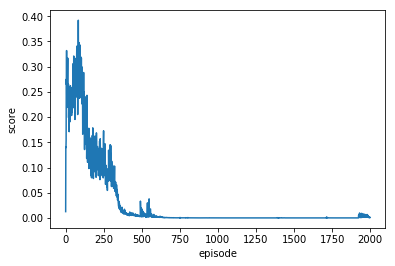

In [6]:
plt.plot(err_list)
plt.xlabel('episode')
plt.ylabel('score')
plt.show()

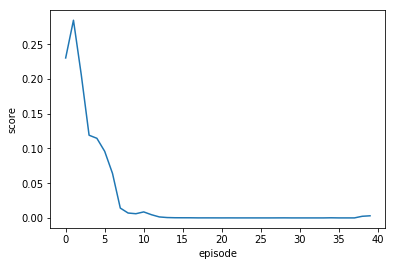

In [7]:
cnt = 0
a = 0
err_li = []
for i in (err_list):
    cnt += 1
    a += i
    if cnt == 50:
        err_li.append(a/cnt)
        cnt = 0
        a = 0
plt.plot(err_li)
plt.xlabel('episode')
plt.ylabel('score')
plt.show()

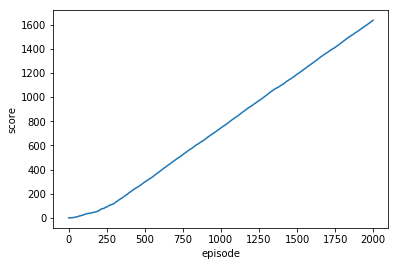

In [5]:
plt.plot(score_list)
plt.xlabel('episode')
plt.ylabel('score')
plt.show()